[Table of Contents](./table_of_contents.ipynb)

# Discrete Bayes Filter

In [1]:
%matplotlib inline

In [2]:
#format the book
import book_format
book_format.set_style()

Фильтр Калмана относится к семейству фильтров, называемых *байесовскими фильтрами*. В большинстве учебников, посвященных фильтру Калмана, приводится формула Байеса, возможно, показывается, как она входит в уравнения фильтра Калмана, но в основном обсуждение ведется на очень абстрактном уровне. 

Такой подход требует достаточно глубокого понимания нескольких областей математики, и при этом большая часть работы по пониманию и формированию интуитивного понимания ситуации остается в руках читателя.

Я буду использовать другой способ развития темы, которым я очень обязан работам Дитера Фокса и Себастьяна Труна. Он зависит от формирования интуитивного представления о том, как работает байесовская статистика, путем отслеживания объекта в коридоре - они используют робота, я - собаку. Мне нравятся собаки, и они менее предсказуемы, чем роботы, что создает интересные трудности для фильтрации. Первый опубликованный пример такого подхода, который я смог найти, кажется, был опубликован в Fox 1999 [1], а более полный пример - в Fox 2003 [2]. Себастьян Трун также использует эту формулировку в своем замечательном курсе Udacity "Искусственный интеллект для робототехники" [3]. На самом деле, если вы любите смотреть видео, я настоятельно рекомендую прервать чтение этой книги в пользу первых нескольких уроков этого курса, а затем вернуться к этой книге для более глубокого погружения в тему.

Теперь давайте проведем простой мысленный эксперимент, подобный тому, что мы делали с g-h фильтром, чтобы посмотреть, как можно рассуждать об использовании вероятностей для фильтрации и отслеживания.

## Слежение за собакой

Начнем с простой проблемы. У нас есть рабочее место, удобное для собак, и люди приводят своих питомцев на работу. Иногда собаки выходят из кабинетов в коридоры. Мы хотим иметь возможность их отслеживать. Поэтому в ходе хакатона кто-то придумал сонарный датчик, который можно прикрепить к ошейнику собаки. Он издает сигнал, слушает эхо и по тому, как быстро возвращается эхо, определяет, находится ли собака перед открытым дверным проемом или нет. Кроме того, устройство определяет, когда собака ходит, и сообщает, в каком направлении она двигалась. Устройство подключается к сети через Wi-Fi и отправляет обновление раз в секунду.

Я хочу отследить своего пса Саймона, поэтому прикрепляю устройство к его ошейнику и запускаю Python, готовый написать код для отслеживания его перемещения по зданию. На первый взгляд это может показаться невозможным. Если я начну слушать датчик ошейника Саймона, то смогу прочитать **дверь**, **зал**, **коридор** и так далее. Как я могу использовать эту информацию, чтобы определить, где находится Саймон?

Для того чтобы задача была достаточно маленькой и ее можно было легко изобразить, мы предположим, что в коридоре имеется только 10 позиций, которые мы пронумеруем от 0 до 9, где 1 находится справа от 0. По причинам, которые станут ясны позже, мы также предположим, что коридор является круглым или прямоугольным. Если вы переместитесь вправо из позиции 9, то окажетесь в позиции 0.  

Когда я начинаю прослушивать датчик, у меня нет оснований полагать, что Саймон находится в каком-то определенном месте коридора. С моей точки зрения, он с равной вероятностью может находиться в любом положении. Существует 10 позиций, поэтому вероятность того, что он находится в любой из них, равна 1/10. 

Представим наше мнение о его положении в массиве NumPy. Я мог бы использовать список Python, но массивы NumPy обладают функциональностью, которую мы будем использовать в ближайшее время.



In [3]:
import numpy as np
belief = np.array([1/10]*10)
print(belief)

[0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1]


В [Байесовской статистике] (https://en.wikipedia.org/wiki/Bayesian_probability) это называется [*приор*] (https://en.wikipedia.org/wiki/Prior_probability). Это вероятность, предшествующая включению измерений или другой информации. В более общем виде это называется *распределением вероятностей*. Распределение вероятностей [*probability distribution*](https://en.wikipedia.org/wiki/Probability_distribution) - это совокупность всех возможных вероятностей события. Распределение вероятностей всегда равно 1, поскольку что-то должно было произойти; в распределении перечислены все возможные события и вероятность каждого из них.

Я уверен, что вы уже использовали вероятности - например, "вероятность дождя сегодня составляет 30%". Последний абзац звучит как нечто подобное. Но байесовская статистика стала революцией в теории вероятностей, поскольку в ней вероятность рассматривается как убеждение относительно одного события. Рассмотрим пример. Я знаю, что если я подброшу честную монету бесконечно много раз, то получу 50% голов и 50% решек. Это называется [*частотной статистикой*] (https://en.wikipedia.org/wiki/Frequentist_inference), чтобы отличить ее от байесовской статистики. Вычисления основаны на частоте возникновения событий.

Я подбрасываю монету еще раз и даю ей упасть. Как я полагаю, в какую сторону она упала? Частотная вероятность ничего не может сказать по этому поводу; она просто констатирует, что 50% подбрасываний монеты выпадает в виде голов. В некотором смысле бессмысленно приписывать вероятность текущему состоянию монеты. Это либо голова, либо решка, мы просто не знаем, что именно. Байес рассматривает это как убеждение относительно одного события - сила моего убеждения или знания, что в данном конкретном случае монета упала головой, составляет 50%. Некоторые возражают против термина "вера"; вера может подразумевать, что что-то считается истинным без доказательств. В этой книге речь всегда идет о мере силы наших знаний. Мы узнаем об этом больше по ходу работы.

Байесовская статистика учитывает прошлую информацию (предшествующую). Мы наблюдаем, что каждые 100 дней дождь идет 4 раза. Исходя из этого, я могу утверждать, что вероятность дождя завтра равна 1/25. Прогнозирование погоды осуществляется не так. Если я знаю, что сегодня идет дождь, а грозовой фронт заторможен, то, скорее всего, дождь пойдет и завтра. Прогнозирование погоды является байесовским.

На практике статистики используют сочетание частотных и байесовских методов. Иногда нахождение предшествующего фактора затруднено или невозможно, и тогда на помощь приходят частотные методы. В этой книге мы сможем найти приоритет. Когда я говорю о вероятности чего-либо, я имею в виду вероятность того, что какая-то конкретная вещь окажется истинной с учетом прошлых событий. Когда я это делаю, я использую байесовский подход.

Теперь давайте создадим карту коридора. Расположим первые две двери близко друг к другу, а затем еще одну дверь подальше. Для дверей мы будем использовать 1, а для стен - 0:

In [4]:
hallway = np.array([1, 1, 0, 0, 0, 0, 0, 0, 1, 0])

Я начинаю прослушивать передачи Саймона по сети, и первые данные, которые я получаю от датчика, - это **door**. На данный момент предполагается, что датчик всегда возвращает правильный ответ. Из этого я делаю вывод, что он находится перед дверью, но какой именно? У меня нет оснований полагать, что он находится перед первой, второй или третьей дверью. Что я могу сделать, так это присвоить каждой двери определенную вероятность. Все двери равновероятны, а их три, поэтому я присваиваю каждой двери вероятность 1/3.

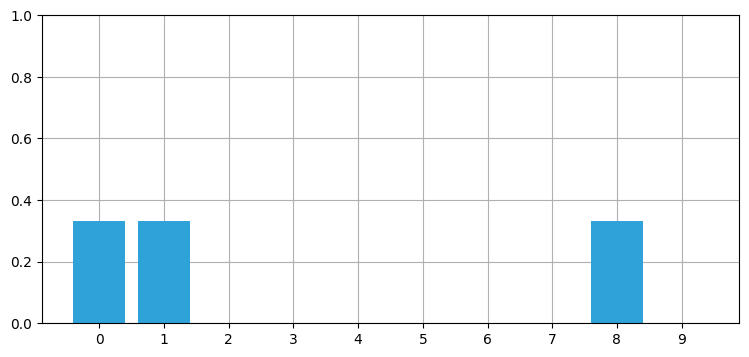

In [5]:
import kf_book.book_plots as book_plots
from kf_book.book_plots import figsize, set_figsize
import matplotlib.pyplot as plt

belief = np.array([1/3, 1/3, 0, 0, 0, 0, 0, 0, 1/3, 0])
book_plots.bar_plot(belief)

Это распределение называется [*категориальным распределением*](https://en.wikipedia.org/wiki/Categorical_distribution), которое представляет собой дискретное распределение, описывающее вероятность наблюдения $n$ исходов. Это [*мультимодальное распределение*](https://en.wikipedia.org/wiki/Multimodal_distribution), поскольку у нас есть несколько убеждений относительно положения нашей собаки. Конечно, мы не говорим, что считаем, что собака одновременно находится в трех разных местах, а просто сужаем круг своих знаний до одного из этих трех мест. Мое (байесовское) убеждение состоит в том, что вероятность того, что собака находится у двери 0, составляет 33,3%, у двери 1 - 33,3%, а у двери 8 - 33,3%.

Это улучшение в двух отношениях. Я отверг ряд позиций в коридоре как невозможные, а сила моей веры в оставшиеся позиции возросла с 10% до 33%. Так будет происходить всегда. По мере совершенствования наших знаний вероятности будут приближаться к 100%.

Несколько слов о [*моде*](https://en.wikipedia.org/wiki/Mode_%28statistics%29)
распределении. Если задан список чисел, например {1, 2, 2, 2, 3, 3, 4}, то *мода* - это число, которое встречается чаще всего. Для данного набора модой является 2. Распределение может содержать более одной моды. Список {1, 2, 2, 2, 3, 3, 4, 4, 4} содержит моды 2 и 4, поскольку обе встречаются по три раза. Мы говорим, что первый список является [*унимодальным*](https://en.wikipedia.org/wiki/Unimodality), а второй - *мультимодальным*.

Другим термином, используемым для обозначения такого распределения, является [*гистограмма*](https://en.wikipedia.org/wiki/Histogram). Гистограммы графически изображают распределение набора чисел. Приведенная выше гистограмма является гистограммой.

В приведенном выше коде я вручную закодировал массив `belief`. Как бы мы реализовали это в коде? Мы представляем двери как 1, а стены как 0, поэтому мы умножим переменную "коридор" на процент, например, так;

In [7]:
belief = hallway * (1/3)
print(belief)

[0.333 0.333 0.    0.    0.    0.    0.    0.    0.333 0.   ]


## Извлечение информации из показаний датчиков

Давайте отложим Python в сторону и немного подумаем над проблемой. Предположим, что мы получили от датчика Саймона следующие данные:

  * дверь
  * движение вправо
  * дверь
  

Можем ли мы определить местоположение Саймона? Конечно! Учитывая расположение коридора, есть только одно место, откуда можно получить эту последовательность, и оно находится в левом конце. Поэтому мы можем с уверенностью утверждать, что Саймон находится перед вторым дверным проемом. Если это непонятно, предположим, что Саймон начал движение от второй или третьей двери. После перемещения вправо его датчик выдал бы ответ "стена". Это не соответствует показаниям датчика, поэтому мы знаем, что он начал не с этого места. Мы можем продолжить эту логику для всех оставшихся стартовых позиций. Единственная возможность заключается в том, что он сейчас находится перед второй дверью. Мы считаем, что это так:

In [8]:
belief = np.array([0., 1., 0., 0., 0., 0., 0., 0., 0., 0.])

Я разработал схему коридора и показания датчиков, чтобы быстро получить точный ответ. Реальные задачи не так однозначны. Но здесь должна сработать ваша интуиция: первое показание датчика дало нам только низкую вероятность (0,333) для местоположения Саймона, но после обновления позиции и еще одного показания датчика мы знаем больше о том, где он находится. Вы могли бы предположить, что если бы у вас был очень длинный коридор с большим количеством дверей, то после нескольких считываний датчиков и обновления позиций мы либо смогли бы узнать, где находится Саймон, либо сузили бы круг возможных вариантов до небольшого числа. Это возможно, когда набор показаний датчиков совпадает только с одним или несколькими начальными местоположениями.

Мы могли бы реализовать это решение уже сейчас, но вместо этого рассмотрим усложнение проблемы в реальном мире.

## Шумные датчики

Идеальные датчики встречаются редко. Возможно, датчик не обнаружит дверь, если Саймон сидит перед ней, почесываясь, или ошибется, если он стоит не лицом к коридору. Таким образом, когда я получаю **дверь**, я не могу использовать 1/3 в качестве вероятности. Я должен присвоить каждой двери менее 1/3, а каждой глухой стене - небольшую вероятность. Что-то вроде

```Python
[.31, .31, .01, .01, .01, .01, .01, .01, .31, .01]
```

Поначалу эта проблема может показаться непреодолимой. Если датчик шумит, то это ставит под сомнение все данные. Как мы можем сделать вывод, если мы всегда не уверены?

Ответ, как и в случае с вышеописанной проблемой, заключается в использовании вероятностей. Нам уже удобно назначать вероятностное убеждение для местонахождения собаки; теперь мы должны учесть дополнительную неопределенность, вызванную шумом датчика. 

Допустим, мы получаем показания **door**, и предположим, что тестирование показывает, что вероятность того, что датчик окажется прав, в 3 раза выше, чем вероятность того, что он ошибется. Мы должны масштабировать распределение вероятностей на 3 там, где есть дверь. Если это сделать, то результат перестанет быть распределением вероятностей, но мы сейчас узнаем, как это исправить.

Давайте посмотрим на это в коде Python. Здесь я использую переменную `z` для обозначения измерения. В литературе для обозначения измерения принято использовать `z` или `y`. Как программист я предпочитаю осмысленные имена переменных, но я хочу, чтобы вы могли читать литературу и/или другой фильтрующий код, поэтому я начну вводить эти сокращенные имена уже сейчас.

[0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1]
belief: [0.3 0.3 0.1 0.1 0.1 0.1 0.1 0.1 0.3 0.1]
sum = 1.6000000000000003


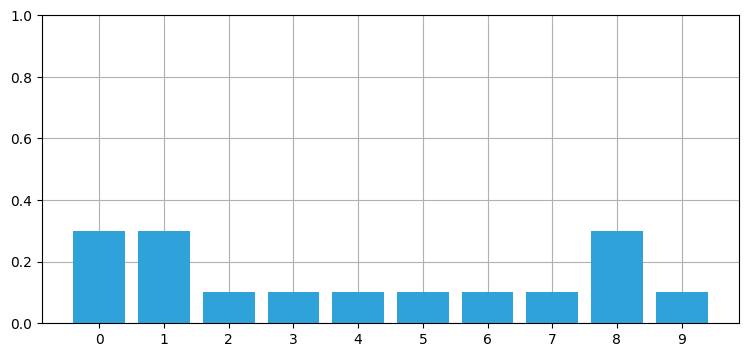

In [11]:
def update_belief(hall, belief, z, correct_scale):
    for i, val in enumerate(hall):
        if val == z:
            belief[i] *= correct_scale

belief = np.array([0.1] * 10)
print(belief)
reading = 1 # 1 is 'door'
update_belief(hallway, belief, z=reading, correct_scale=3.)
print('belief:', belief)
print('sum =', sum(belief))
plt.figure()
book_plots.bar_plot(belief)

Это не распределение вероятностей, поскольку его сумма не равна 1,0. Но код поступает в основном правильно - дверям присваивается число (0.3), которое в 3 раза больше, чем стенам (0.1). Осталось только нормализовать результат, чтобы вероятности правильно складывались в 1,0. Нормализация выполняется путем деления каждого элемента на сумму всех элементов списка. Это легко сделать с помощью NumPy:

In [12]:
belief / sum(belief)

array([0.188, 0.188, 0.062, 0.062, 0.062, 0.062, 0.062, 0.062, 0.188,
       0.062])

В FilterPy это реализовано с помощью функции `normalize`:

```Python
from filterpy.discrete_bayes import normalize
normalize(belief)
```

Немного странно говорить "вероятность того, что датчик окажется верным, в 3 раза выше, чем вероятность того, что он окажется неверным". Мы работаем с вероятностями, поэтому зададим вероятность того, что датчик окажется верным, и вычислим из нее масштабный коэффициент. Уравнение для этого выглядит следующим образом

$$scale =  \frac{prob_{correct}}{prob_{incorrect}} = \frac{prob_{correct}} {1-prob_{correct}}$$

Кроме того, цикл `for` является громоздким. Как правило, в коде NumPy лучше избегать использования циклов `for`. NumPy реализован на языках C и Fortran, поэтому если избегать циклов for, то результат часто выполняется в 100 раз быстрее, чем эквивалентный цикл.

Как же избавиться от цикла `for`? NumPy позволяет индексировать массивы с помощью булевых массивов. Вы создаете булевский массив с помощью логических операторов. Мы можем найти все двери в коридоре с помощью:

In [13]:
hallway == 1

array([ True,  True, False, False, False, False, False, False,  True,
       False])

При использовании булевого массива в качестве индекса к другому массиву он возвращает только те элементы, для которых индекс равен `True`. Таким образом, мы можем заменить цикл `for` на

```python
belief[hall==z] *= scale
```
и только те элементы, которые равны `z`, будут умножены на `scale`.

Обучение NumPy выходит за рамки этой книги. Я буду использовать идиоматические конструкции NumPy и объяснять их при первом знакомстве. Если вы новичок в NumPy, то в блогах можно найти множество статей и видеороликов о том, как эффективно и идиоматично использовать NumPy.

Вот наша улучшенная версия:

sum = 1.0
probability of door = 0.1875
probability of wall = 0.06249999999999999


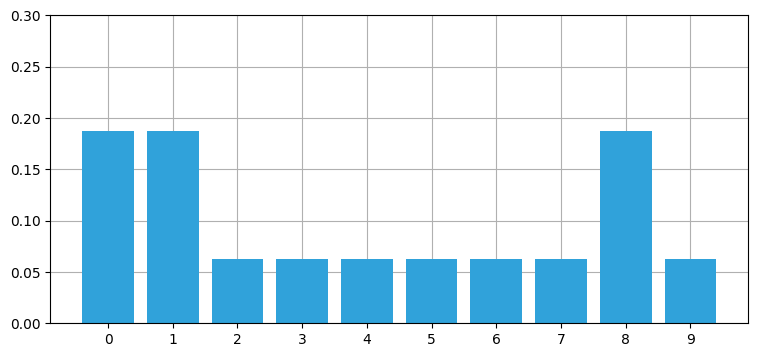

In [14]:
from filterpy.discrete_bayes import normalize

def scaled_update(hall, belief, z, z_prob): 
    scale = z_prob / (1. - z_prob)
    belief[hall==z] *= scale
    normalize(belief)

belief = np.array([0.1] * 10)
scaled_update(hallway, belief, z=1, z_prob=.75)

print('sum =', sum(belief))
print('probability of door =', belief[0])
print('probability of wall =', belief[2])
book_plots.bar_plot(belief, ylim=(0, .3))

Из результата видно, что сумма теперь равна 1,0, а вероятность двери по сравнению со стеной по-прежнему в три раза больше. Результат также соответствует нашей интуиции, согласно которой вероятность двери должна быть меньше 0,333, а вероятность стены - больше 0,0. Наконец, результат должен соответствовать интуиции, согласно которой нам еще не предоставлена информация, позволяющая отличить одно положение двери или стены от другого, поэтому все положения двери должны иметь одинаковое значение, и то же самое должно быть верно для положений стены.
 
Такой результат называется [*posterior*](https://en.wikipedia.org/wiki/Posterior_probability), что является сокращением от *posterior probability distribution*. Все это означает, что распределение вероятностей будет получено после учета информации об измерениях (posterior в данном контексте означает "после"). Для сравнения, *приор* - это распределение вероятностей до включения информации об измерении.

Другой термин - [*вероятность*](https://en.wikipedia.org/wiki/Likelihood_function). Когда мы вычисляли `belief[hall==z] *= scale`, мы вычисляли, насколько *вероятно* каждое положение с учетом измерения. Вероятность не является распределением вероятностей, поскольку ее сумма не равна единице.

Их комбинация дает уравнение

$$\mathtt{posterior} = \frac{\mathtt{likelihood} \times \mathtt{prior}}{\mathtt{normalization}}$$ 

Когда мы говорим о выходе фильтра, то обычно называем состояние после выполнения предсказания *предшественником* или *предсказанием*, а состояние после обновления - *постериорным* или *оцененным состоянием*. 

Очень важно выучить и усвоить эти термины, поскольку в большинстве литературы они широко используются.

Выполняет ли `scaled_update()` эти вычисления? Выполняет. Перефразируем его в следующем виде:

In [15]:
def scaled_update(hall, belief, z, z_prob): 
    scale = z_prob / (1. - z_prob)
    likelihood = np.ones(len(hall))
    likelihood[hall==z] *= scale
    return normalize(likelihood * belief)

Эта функция не является полностью общей. Она содержит знания о коридоре и о том, как мы сопоставляем с ним измерения. Мы всегда стремимся писать общие функции. Здесь мы уберем вычисление вероятности из функции и потребуем, чтобы вызывающая сторона сама вычислила вероятность.

Вот полная реализация алгоритма:

```python
def update(likelihood, prior):
    return normalize(likelihood * prior)
```

Вычисление вероятности зависит от конкретной задачи. Например, датчик может возвращать не просто 1 или 0, а `float` между 0 и 1, указывающий на вероятность нахождения перед дверью. Он может использовать компьютерное зрение и сообщать о форме объекта, который затем вероятностно сопоставляется с дверью. Может использоваться гидролокатор и выдавать показания расстояния. В каждом случае вычисление вероятности будет отличаться. На протяжении всей книги мы увидим множество примеров и научимся выполнять эти расчеты.

FilterPy реализует функцию `update`. Приведем предыдущий пример в общем виде:

In [17]:
from filterpy.discrete_bayes import update

def lh_hallway(hall, z, z_prob):
    """ compute likelihood that a measurement matches
    positions in the hallway."""
    
    try:
        scale = z_prob / (1. - z_prob)
    except ZeroDivisionError:
        scale = 1e8

    likelihood = np.ones(len(hall))
    likelihood[hall==z] *= scale
    return likelihood

belief = np.array([0.1] * 10)
likelihood = lh_hallway(hallway, z=1, z_prob=.75)
update(likelihood, belief)  

array([0.188, 0.188, 0.062, 0.062, 0.062, 0.062, 0.062, 0.062, 0.188,
       0.062])

## Включение движения

Вспомните, как быстро нам удалось найти точное решение, когда мы включили в него серию измерений и обновлений движения. Однако это происходило в вымышленном мире идеальных датчиков. Сможем ли мы найти точное решение при наличии шумящих датчиков?

К сожалению, ответ отрицательный. Даже если показания датчиков идеально соответствуют чрезвычайно сложной карте коридора, мы не можем быть на 100% уверены в том, что собака находится в определенном положении - ведь существует ничтожная вероятность того, что каждое показание датчика было ошибочным! Естественно, в более типичной ситуации большинство показаний датчиков будут правильными, и мы можем быть близки к 100% уверенности в своем ответе, но никогда не будем уверены на 100%. Это может показаться сложным, но давайте продолжим программировать математику.

Сначала разберемся с простым случаем - предположим, что датчик движения совершенен и сообщает, что собака переместилась на одно место вправо. Как мы изменим наш массив `belief`?

Надеюсь, что после минутного размышления станет ясно, что нам следует сдвинуть все значения на одно место вправо. Если раньше мы считали, что вероятность того, что Саймон находится на позиции 3, составляет 50%, то после того, как он переместился на одну позицию вправо, мы должны считать, что вероятность того, что он находится на позиции 4, составляет 50%. Коридор является круговым, поэтому для выполнения сдвига мы будем использовать арифметику по модулю.

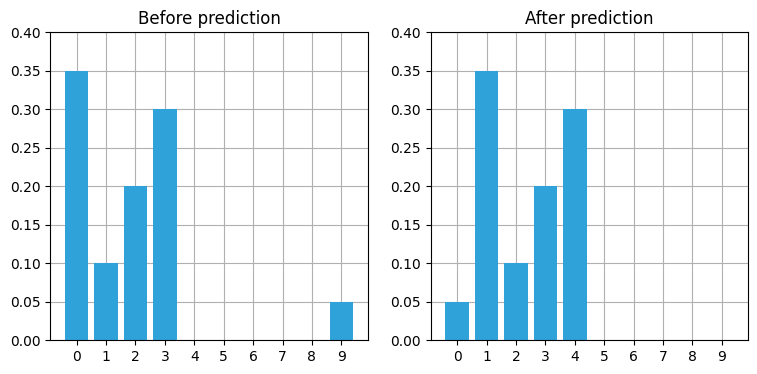

In [18]:
def perfect_predict(belief, move):
    """ move the position by `move` spaces, where positive is 
    to the right, and negative is to the left
    """
    n = len(belief)
    result = np.zeros(n)
    for i in range(n):
        result[i] = belief[(i-move) % n]
    return result
        
belief = np.array([.35, .1, .2, .3, 0, 0, 0, 0, 0, .05])
plt.subplot(121)
book_plots.bar_plot(belief, title='Before prediction', ylim=(0, .4))

belief = perfect_predict(belief, 1)
plt.subplot(122)
book_plots.bar_plot(belief, title='After prediction', ylim=(0, .4))

Видно, что мы правильно сдвинули все значения на одну позицию вправо, обернув их от конца массива обратно к началу. 

В следующей ячейке показана анимация, чтобы вы могли увидеть это в действии. Используйте ползунок для перемещения вперед и назад во времени. Это имитирует хождение Саймона по коридору и обратно. Он еще не учитывает новые измерения, поэтому распределение вероятностей не меняет форму, а только положение.

In [19]:
from ipywidgets import interact, IntSlider

belief = np.array([.35, .1, .2, .3, 0, 0, 0, 0, 0, .05])
perfect_beliefs = []

for _ in range(20):
    # Simon takes one step to the right
    belief = perfect_predict(belief, 1)
    perfect_beliefs.append(belief)

def simulate(time_step):
    book_plots.bar_plot(perfect_beliefs[time_step], ylim=(0, .4))
    plt.show()
    
interact(simulate, time_step=IntSlider(value=0, max=len(perfect_beliefs)-1));

interactive(children=(IntSlider(value=0, description='time_step', max=19), Output()), _dom_classes=('widget-in…

## Терминология

Давайте сделаем небольшую паузу, чтобы рассмотреть терминологию. Я ввел эту терминологию в предыдущей главе, но давайте сделаем паузу, чтобы закрепить ваши знания. 

Система - это то, что мы пытаемся смоделировать или отфильтровать. В данном случае система - это наша собака. Состояние* - это ее текущая конфигурация или значение. В данной главе состояние - это положение нашей собаки. Мы редко знаем реальное состояние, поэтому мы говорим, что наши фильтры производят *оценочное состояние* системы. На практике это часто называют состоянием, поэтому будьте внимательны, чтобы понять контекст.
 
Один цикл предсказания и обновления при измерении называется *эволюцией состояния или системы*, что является сокращением от *временной эволюции* [7]. Другой термин - *распространение системы*. Он относится к тому, как изменяется состояние системы с течением времени. Для фильтров время обычно является дискретным шагом, например, 1 секунда. Для нашего трекера состояние системы - это положение собаки, а эволюция состояния - это положение собаки по прошествии дискретного промежутка времени.

Мы моделируем поведение системы с помощью *модели процесса*. Здесь наша модель процесса заключается в том, что на каждом временном шаге собака перемещается на одну или несколько позиций. Это не совсем точная модель поведения собак. Ошибка в модели называется *системной ошибкой* или *ошибкой процесса*. 

Прогноз - это наш новый *prior*. Время сдвинулось вперед, и мы сделали предсказание, не зная результатов измерений. 

Рассмотрим пример. Текущее положение собаки - 17 м. Наша эпоха длится 2 секунды, и собака движется со скоростью 15 м/с. Где, по нашему прогнозу, она будет находиться через 2 секунды? 

Ясно,

$$ \begin{aligned}
\bar x &= 17 + (15*2) \\
&= 47
\end{aligned}$$

Я использую столбики над переменными, чтобы указать, что они являются приорными (предсказаниями). Мы можем записать уравнение для модели процесса следующим образом:

$$ \bar x_{k+1} = f_x(\bullet) + x_k$$

$x_k$ - это текущее положение или состояние. Если собака находится на расстоянии 17 м, то $x_k = 17$.

$f_x(\bullet)$ - это функция распространения состояния для x. Она описывает, насколько изменяется $x_k$ за один шаг по времени. Для нашего примера она выполняет вычисления $15 \cdot 2$, поэтому мы определим ее как

$$ f_{x}(v_{x}, t) = v_{k} t.


## Добавление неопределенности в предсказание

Функция `perfect_predict()` предполагает идеальные измерения, но все датчики имеют шумы. Что, если датчик сообщает, что наша собака переместилась на одно место, а на самом деле она переместилась на два места или на ноль? Это может показаться непреодолимой проблемой, но давайте смоделируем ее и посмотрим, что получится.

Предположим, что измерение перемещения датчиком с вероятностью 80% будет правильным, с вероятностью 10% он отклонится на одну позицию вправо, и с вероятностью 10% он отклонится влево. То есть, если измерение перемещения равно 4 (то есть 4 места вправо), то с вероятностью 80% собака переместилась на 4 места вправо, 10% - на 3 места и 10% - на 5 мест.

Теперь каждый результат в массиве должен включать в себя вероятности для трех различных ситуаций. Например, рассмотрим сообщение о перемещении 2. Если мы на 100% уверены, что собака начала движение с позиции 3, то с вероятностью 80% она находится на позиции 5, а с вероятностью 10% - на позиции 4 или 6. Попробуем закодировать это:

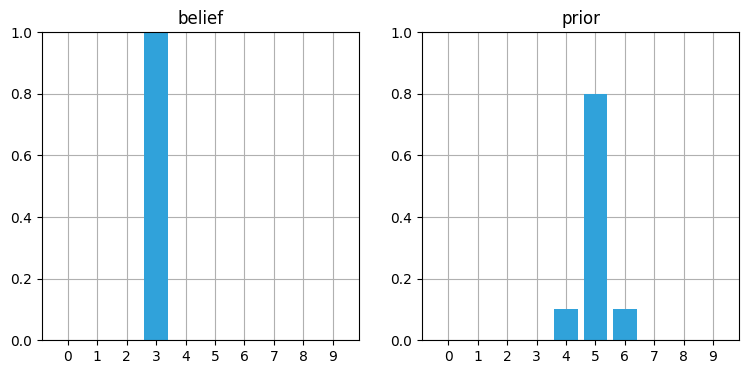

In [20]:
def predict_move(belief, move, p_under, p_correct, p_over):
    n = len(belief)
    prior = np.zeros(n)
    for i in range(n):
        prior[i] = (
            belief[(i-move) % n]   * p_correct +
            belief[(i-move-1) % n] * p_over +
            belief[(i-move+1) % n] * p_under)      
    return prior

belief = [0., 0., 0., 1., 0., 0., 0., 0., 0., 0.]
prior = predict_move(belief, 2, .1, .8, .1)
book_plots.plot_belief_vs_prior(belief, prior)

Кажется, что все работает правильно. Что же происходит, когда наше убеждение не является на 100% уверенным?

array([0.  , 0.  , 0.  , 0.04, 0.38, 0.52, 0.06, 0.  , 0.  , 0.  ])

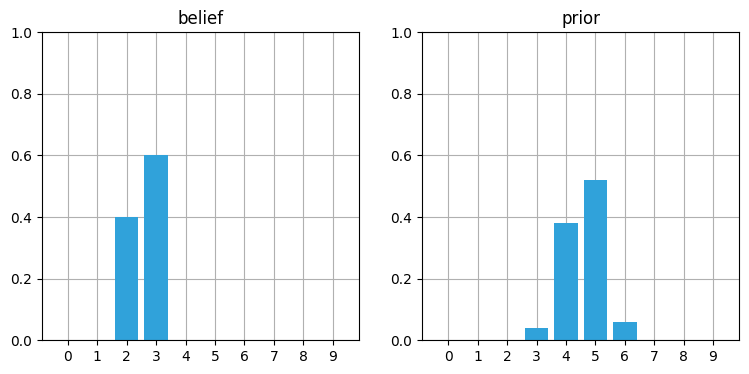

In [21]:
belief = [0, 0, .4, .6, 0, 0, 0, 0, 0, 0]
prior = predict_move(belief, 2, .1, .8, .1)
book_plots.plot_belief_vs_prior(belief, prior)
prior

Здесь результаты более сложные, но вы должны быть в состоянии разобраться с ними. Величина 0.04 обусловлена возможностью того, что вера в 0.4 занижена на 1. Величина 0.38 обусловлена следующим: 80% вероятности того, что мы сдвинулись на 2 позиции (0.4 $\times$ 0.8) и 10% вероятности того, что мы занизили позицию (0.6 $\times$ 0.1). Перебор здесь не играет никакой роли, потому что если бы мы переборщили, то и 0.4, и 0.6 были бы уже за этой позицией. **Я настоятельно рекомендую проработать несколько примеров, пока все это не станет ясно, поскольку от понимания этого шага зависит очень многое из того, что последует дальше.

Если вы посмотрите на вероятности после выполнения обновления, вы можете быть обескуражены. В приведенном выше примере мы начали с вероятностей 0,4 и 0,6 в двух позициях; после обновления вероятности не только уменьшились, но и рассыпались по карте.

Это не случайность и не результат тщательно подобранного примера - это всегда так для прогноза. Если датчик зашумлен, то мы теряем часть информации при каждом предсказании. Предположим, что мы будем выполнять предсказание бесконечное число раз - каков будет результат? Если мы теряем информацию на каждом шаге, то в конечном итоге мы не должны иметь никакой информации вообще, и наши вероятности будут равномерно распределены по массиву `доверия`. Попробуем сделать это на 100 итерациях. График анимирован; для изменения числа шагов используйте ползунок.

In [22]:
belief = np.array([1.0, 0, 0, 0, 0, 0, 0, 0, 0, 0])
predict_beliefs = []
    
for i in range(100):
    belief = predict_move(belief, 1, .1, .8, .1)
    predict_beliefs.append(belief)

print('Final Belief:', belief)

# make interactive plot
def show_prior(step):
    book_plots.bar_plot(predict_beliefs[step-1])
    plt.title(f'Step {step}')
    plt.show()

interact(show_prior, step=IntSlider(value=1, max=len(predict_beliefs)));

Final Belief: [0.104 0.103 0.101 0.099 0.097 0.096 0.097 0.099 0.101 0.103]


interactive(children=(IntSlider(value=1, description='step'), Output()), _dom_classes=('widget-interact',))

In [23]:
print('Final Belief:', belief)

Final Belief: [0.104 0.103 0.101 0.099 0.097 0.096 0.097 0.099 0.101 0.103]


После 100 итераций мы потеряли практически всю информацию, хотя были на 100% уверены, что начали с позиции 0. Не стесняйтесь играть с числами, чтобы увидеть эффект от разного количества обновлений. Например, после 100 обновлений остается небольшое количество информации, после 50 - большое, а к 200 итерациям теряется практически вся информация.

А если вы смотрите эту статью в Интернете, то вот анимация этого вывода.
<img src="animations/02_no_info.gif">

В остальной части книги я не буду генерировать эти автономные анимации. Пожалуйста, обратитесь к предисловию, чтобы получить инструкции по бесплатному запуску этой книги в Интернете или установить IPython на свой компьютер. Это позволит вам запустить все ячейки и увидеть анимацию. Очень важно, чтобы вы практиковались с этим кодом, а не просто пассивно читали.

## Обобщение с помощью конволюции

We made the assumption that the movement error is at most one position. But it is possible for the error to be two, three, or more positions. As programmers we always want to generalize our code so that it works for all cases. 

This is easily solved with [*convolution*](https://en.wikipedia.org/wiki/Convolution). Convolution modifies one function with another function. In our case we are modifying a probability distribution with the error function of the sensor. The implementation of `predict_move()` is a convolution, though we did not call it that. Formally, convolution is defined as

$$ (f \ast g) (t) = \int_0^t \!f(\tau) \, g(t-\tau) \, \mathrm{d}\tau$$

where $f\ast g$ is the notation for convolving f by g. It does not mean multiply.

Integrals are for continuous functions, but we are using discrete functions. We replace the integral with a summation, and the parenthesis with array brackets.

$$ (f \ast g) [t] = \sum\limits_{\tau=0}^t \!f[\tau] \, g[t-\tau]$$

Comparison shows that `predict_move()` is computing this equation - it computes the sum of a series of multiplications.

[Khan Academy](https://www.khanacademy.org/math/differential-equations/laplace-transform/convolution-integral/v/introduction-to-the-convolution) [4] has a good introduction to convolution, and Wikipedia has some excellent animations of convolutions [5]. But the general idea is already clear. You slide an array called the *kernel* across another array, multiplying the neighbors of the current cell with the values of the second array. In our example above we used 0.8 for the probability of moving to the correct location, 0.1 for undershooting, and 0.1 for overshooting. We make a kernel of this with the array `[0.1, 0.8, 0.1]`. All we need to do is write a loop that goes over each element of our array, multiplying by the kernel, and summing the results. To emphasize that the belief is a probability distribution I have named it `pdf`.

In [20]:
def predict_move_convolution(pdf, offset, kernel):
    N = len(pdf)
    kN = len(kernel)
    width = int((kN - 1) / 2)

    prior = np.zeros(N)
    for i in range(N):
        for k in range (kN):
            index = (i + (width-k) - offset) % N
            prior[i] += pdf[index] * kernel[k]
    return prior

This illustrates the algorithm, but it runs very slow. SciPy provides a convolution routine `convolve()` in the `ndimage.filters` module. We  need to shift the pdf by `offset` before convolution; `np.roll()` does that. The move and predict algorithm can be implemented with one line:

```python
convolve(np.roll(pdf, offset), kernel, mode='wrap')
```

FilterPy implements this with `discrete_bayes`' `predict()` function.

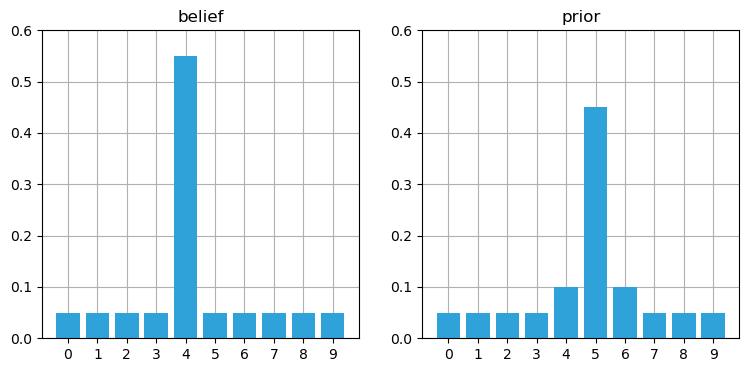

In [21]:
from filterpy.discrete_bayes import predict

belief = [.05, .05, .05, .05, .55, .05, .05, .05, .05, .05]
prior = predict(belief, offset=1, kernel=[.1, .8, .1])
book_plots.plot_belief_vs_prior(belief, prior, ylim=(0,0.6))

All of the elements are unchanged except the middle ones. The values in position 4 and 6 should be 
$$(0.1 \times 0.05)+ (0.8 \times 0.05) + (0.1 \times 0.55) = 0.1$$

Position 5 should be $$(0.1 \times 0.05) + (0.8 \times 0.55)+ (0.1 \times 0.05) = 0.45$$

Let's ensure that it shifts the positions correctly for movements greater than one and for asymmetric kernels.

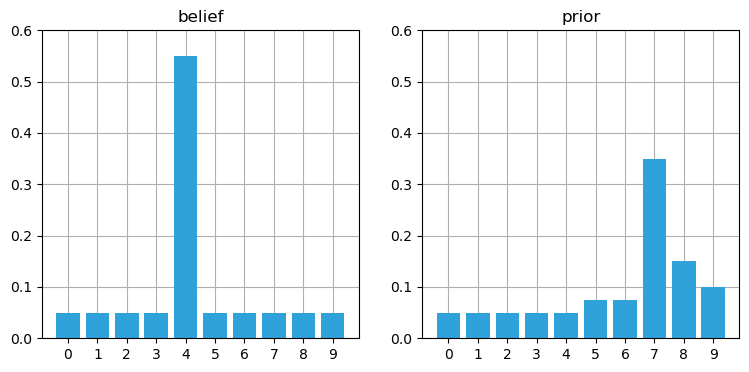

In [22]:
prior = predict(belief, offset=3, kernel=[.05, .05, .6, .2, .1])
book_plots.plot_belief_vs_prior(belief, prior, ylim=(0,0.6))

The position was correctly shifted by 3 positions and we give more weight to the likelihood of an overshoot vs an undershoot, so this looks correct.

Make sure you understand what we are doing. We are making a prediction of where the dog is moving, and convolving the probabilities to get the prior.

If we weren't using probabilities we would use this equation that I gave earlier:

$$ \bar x_{k+1} = x_k + f_{\mathbf x}(\bullet)$$

The prior, our prediction of where the dog will be, is the amount the dog moved plus his current position. The dog was at 10, he moved 5 meters, so he is now at 15 m. It couldn't be simpler. But we are using probabilities to model this, so our equation is:

$$ \bar{ \mathbf x}_{k+1} = \mathbf x_k \ast f_{\mathbf x}(\bullet)$$

We are *convolving* the current probabilistic position estimate with a probabilistic estimate of how much we think the dog moved. It's the same concept, but the math is slightly different. $\mathbf x$ is bold to denote that it is an array of numbers. 

## Integrating Measurements and Movement Updates

The problem of losing information during a prediction may make it seem as if our system would quickly devolve into having no knowledge. However, each prediction is followed by an update where we incorporate the measurement into the estimate. The update improves our knowledge. The output of the update step is fed into the next prediction. The prediction degrades our certainty. That is passed into another update, where certainty is again increased.

Let's think about this intuitively. Consider a simple case - you are tracking a dog while he sits still. During each prediction you predict he doesn't move. Your filter quickly *converges* on an accurate estimate of his position. Then the microwave in the kitchen turns on, and he goes streaking off. You don't know this, so at the next prediction you predict he is in the same spot. But the measurements tell a different story. As you incorporate the measurements your belief will be smeared along the hallway, leading towards the kitchen. On every epoch (cycle) your belief that he is sitting still will get smaller, and your belief that he is inbound towards the kitchen at a startling rate of speed increases.

That is what intuition tells us. What does the math tell us?

We have already programmed the update and predict steps. All we need to do is feed the result of one into the other, and we will have implemented a dog tracker!!! Let's see how it performs. We will input measurements as if the dog started at position 0 and moved right one position each epoch. As in a real world application, we will start with no knowledge of his position by assigning equal probability to all positions. 

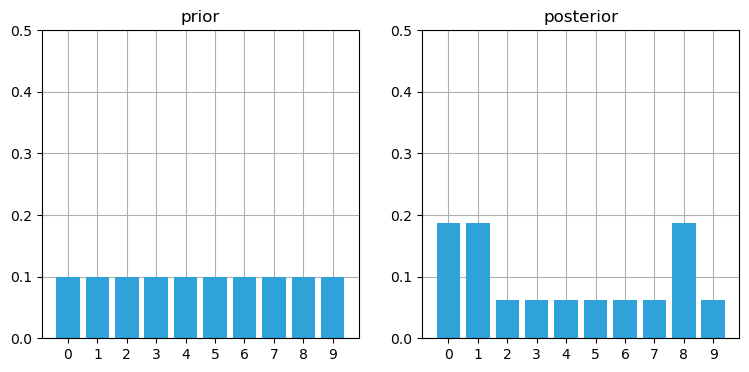

In [23]:
from filterpy.discrete_bayes import update

hallway = np.array([1, 1, 0, 0, 0, 0, 0, 0, 1, 0])
prior = np.array([.1] * 10)
likelihood = lh_hallway(hallway, z=1, z_prob=.75)
posterior = update(likelihood, prior)
book_plots.plot_prior_vs_posterior(prior, posterior, ylim=(0,.5))

После первого обновления мы присвоили высокую вероятность каждому положению двери и низкую вероятность каждому положению стены.

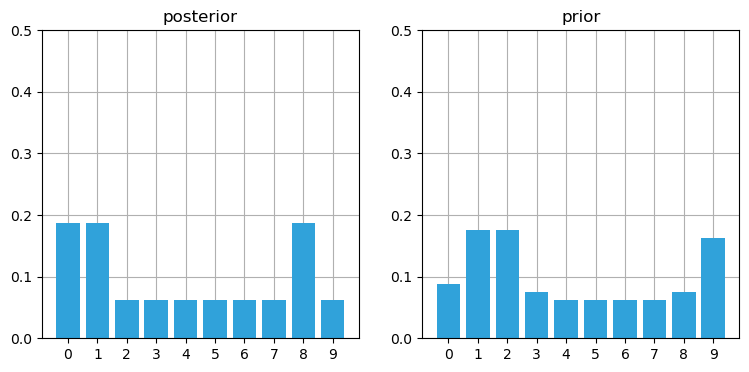

In [24]:
kernel = (.1, .8, .1)
prior = predict(posterior, 1, kernel)
book_plots.plot_prior_vs_posterior(prior, posterior, True, ylim=(0,.5))

Шаг предсказания сдвигает эти вероятности вправо, немного размазывая их. Теперь посмотрим, что происходит на следующем шаге.

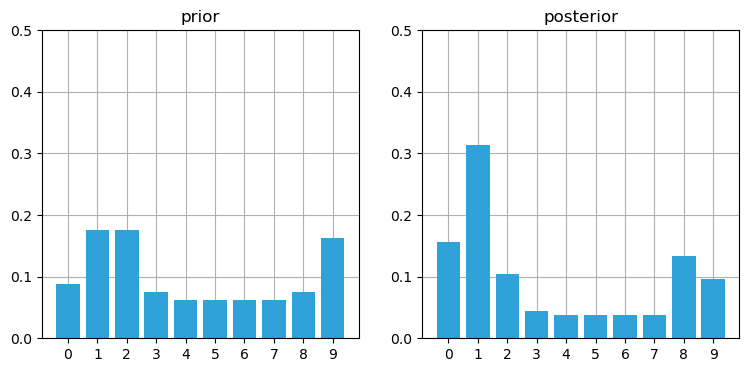

In [25]:
likelihood = lh_hallway(hallway, z=1, z_prob=.75)
posterior = update(likelihood, prior)
book_plots.plot_prior_vs_posterior(prior, posterior, ylim=(0,.5))

Обратите внимание на высокий столбик в позиции 1. Это соответствует (правильному) случаю, когда мы начинаем с позиции 0, чувствуем дверь, сдвигаемся на 1 вправо и чувствуем другую дверь. Никакие другие позиции не делают этот набор наблюдений столь же вероятным. Теперь мы добавим обновление, а затем почувствуем стену.

In [24]:
prior = predict(posterior, 1, kernel)
likelihood = lh_hallway(hallway, z=0, z_prob=.75)
posterior = update(likelihood, prior)
book_plots.plot_prior_vs_posterior(prior, posterior, ylim=(0,.5))

NameError: name 'predict' is not defined

This is exciting! We have a very prominent bar at position 2 with a value of around 35%. It is over twice the value of any other bar in the plot, and is about 4% larger than our last plot, where the tallest bar was around 31%. Let's see one more cycle.

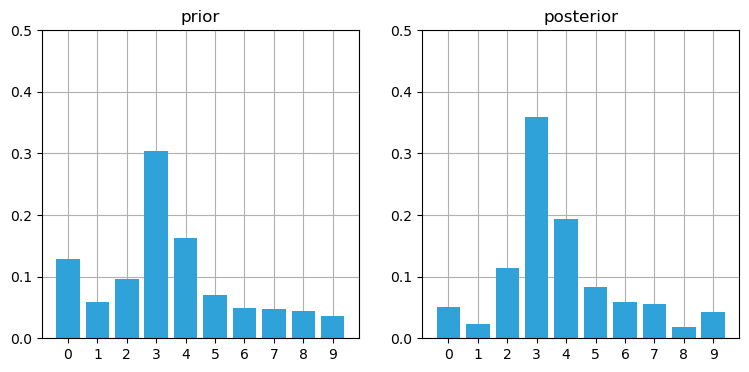

In [27]:
prior = predict(posterior, 1, kernel)
likelihood = lh_hallway(hallway, z=0, z_prob=.75)
posterior = update(likelihood, prior)
book_plots.plot_prior_vs_posterior(prior, posterior, ylim=(0,.5))

I ignored an important issue. Earlier I assumed that we had a motion sensor for the predict step; then, when talking about the dog and the microwave I assumed that you had no knowledge that he suddenly began running. I mentioned that your belief that the dog is running would increase over time, but I did not provide any code for this. In short, how do we detect and/or estimate changes in the process model if we aren't directly measuring it?

For now I want to ignore this problem. In later chapters we will learn the mathematics behind this estimation; for now it is a large enough task just to learn this algorithm. It is profoundly important to solve this problem, but we haven't yet built enough of the mathematical apparatus that is required, and so for the remainder of the chapter we will ignore the problem by assuming we have a sensor that senses movement.

## The Discrete Bayes Algorithm

This chart illustrates the algorithm:

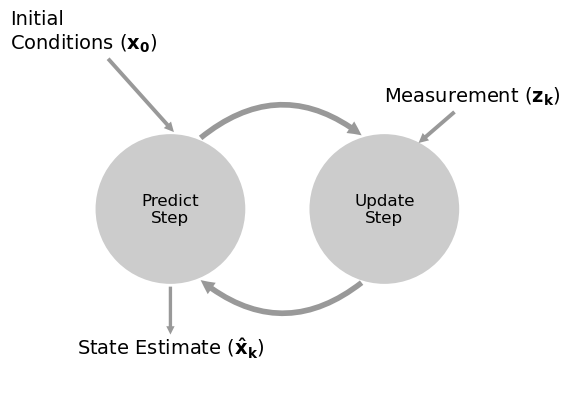

In [28]:
book_plots.predict_update_chart()

This filter is a form of the g-h filter. Here we are using the percentages for the errors to implicitly compute the $g$ and $h$ parameters. We could express the discrete Bayes algorithm as a g-h filter, but that would obscure the logic of this filter.

The filter equations are:

$$\begin{aligned} \bar {\mathbf x} &= \mathbf x \ast f_{\mathbf x}(\bullet)\, \, &\text{Predict Step} \\
\mathbf x &= \|\mathcal L \cdot \bar{\mathbf x}\|\, \, &\text{Update Step}\end{aligned}$$

$\mathcal L$ is the usual way to write the likelihood function, so I use that. The $\|\|$ notation denotes taking the norm. We need to normalize the product of the likelihood with the prior to ensure $x$ is a probability distribution that sums to one.

We can express this in pseudocode.

**Initialization**

    1. Initialize our belief in the state
    
**Predict**

    1. Based on the system behavior, predict state for the next time step
    2. Adjust belief to account for the uncertainty in prediction
    
**Update**

    1. Get a measurement and associated belief about its accuracy
    2. Compute how likely it is the measurement matches each state
    3. Update state belief with this likelihood

When we cover the Kalman filter we will use this exact same algorithm; only the details of the computation will differ.

Algorithms in this form are sometimes called *predictor correctors*. We make a prediction, then correct them.

Let's animate this. First Let's write functions to perform the filtering and to plot the results at any step. I've plotted the position of the doorways in black. Prior are drawn in orange, and the posterior in blue. I draw a thick vertical line to indicate where Simon really is. This is not an output of the filter - we know where Simon is only because we are simulating his movement.

In [29]:
def discrete_bayes_sim(prior, kernel, measurements, z_prob, hallway):
    posterior = np.array([.1]*10)
    priors, posteriors = [], []
    for i, z in enumerate(measurements):
        prior = predict(posterior, 1, kernel)
        priors.append(prior)

        likelihood = lh_hallway(hallway, z, z_prob)
        posterior = update(likelihood, prior)
        posteriors.append(posterior)
    return priors, posteriors


def plot_posterior(hallway, posteriors, i):
    plt.title('Posterior')
    book_plots.bar_plot(hallway, c='k')
    book_plots.bar_plot(posteriors[i], ylim=(0, 1.0))
    plt.axvline(i % len(hallway), lw=5)
    plt.show()
    
def plot_prior(hallway, priors, i):
    plt.title('Prior')
    book_plots.bar_plot(hallway, c='k')
    book_plots.bar_plot(priors[i], ylim=(0, 1.0), c='#ff8015')
    plt.axvline(i % len(hallway), lw=5)
    plt.show()

def animate_discrete_bayes(hallway, priors, posteriors):
    def animate(step):
        step -= 1
        i = step // 2    
        if step % 2 == 0:
            plot_prior(hallway, priors, i)
        else:
            plot_posterior(hallway, posteriors, i)
    
    return animate

Let's run the filter and animate it.

In [30]:
# change these numbers to alter the simulation
kernel = (.1, .8, .1)
z_prob = 1.0
hallway = np.array([1, 1, 0, 0, 0, 0, 0, 0, 1, 0])

# measurements with no noise
zs = [hallway[i % len(hallway)] for i in range(50)]

priors, posteriors = discrete_bayes_sim(prior, kernel, zs, z_prob, hallway)
interact(animate_discrete_bayes(hallway, priors, posteriors), step=IntSlider(value=1, max=len(zs)*2));

interactive(children=(IntSlider(value=1, description='step'), Output()), _dom_classes=('widget-interact',))

Now we can see the results. You can see how the prior shifts the position and reduces certainty, and the posterior stays in the same position and increases certainty as it incorporates the information from the measurement. I've made the measurement perfect with the line `z_prob = 1.0`; we will explore the effect of imperfect measurements in the next section. Finally, 

Another thing to note is how accurate our estimate becomes when we are in front of a door, and how it degrades when in the middle of the hallway. This should make intuitive sense. There are only a few doorways, so when the sensor tells us we are in front of a door this boosts our certainty in our position. A long stretch of no doors reduces our certainty.

## The Effect of Bad Sensor Data

You may be suspicious of the results above because I always passed correct sensor data into the functions. However, we are claiming that this code implements a *filter* - it should filter out bad sensor measurements. Does it do that?

To make this easy to program and visualize I will change the layout of the hallway to mostly alternating doors and hallways, and run the algorithm on 6 correct measurements:

In [31]:
hallway = np.array([1, 0, 1, 0, 0]*2)
kernel = (.1, .8, .1)
prior = np.array([.1] * 10)
zs = [1, 0, 1, 0, 0, 1]
z_prob = 0.75
priors, posteriors = discrete_bayes_sim(prior, kernel, zs, z_prob, hallway)
interact(animate_discrete_bayes(hallway, priors, posteriors), step=IntSlider(value=12, max=len(zs)*2));

interactive(children=(IntSlider(value=12, description='step', max=12), Output()), _dom_classes=('widget-intera…

We have identified the likely cases of having started at position 0 or 5, because we saw this sequence of doors and walls: 1,0,1,0,0. Now I inject a bad measurement. The next measurement should be 0, but instead we get a 1:

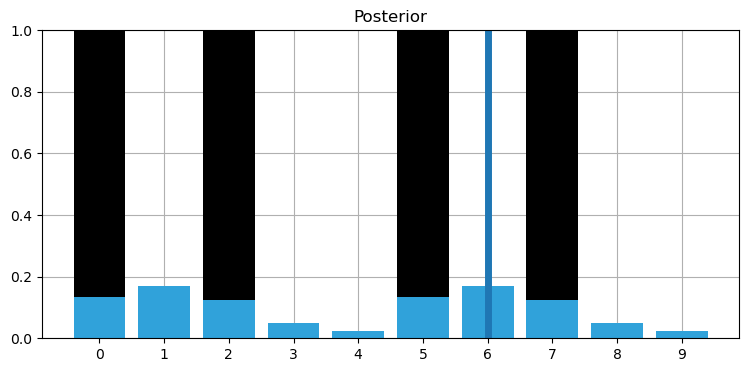

In [32]:
measurements = [1, 0, 1, 0, 0, 1, 1]
priors, posteriors = discrete_bayes_sim(prior, kernel, measurements, z_prob, hallway);
plot_posterior(hallway, posteriors, 6)

That one bad measurement has significantly eroded our knowledge. Now let's continue with a series of correct measurements.

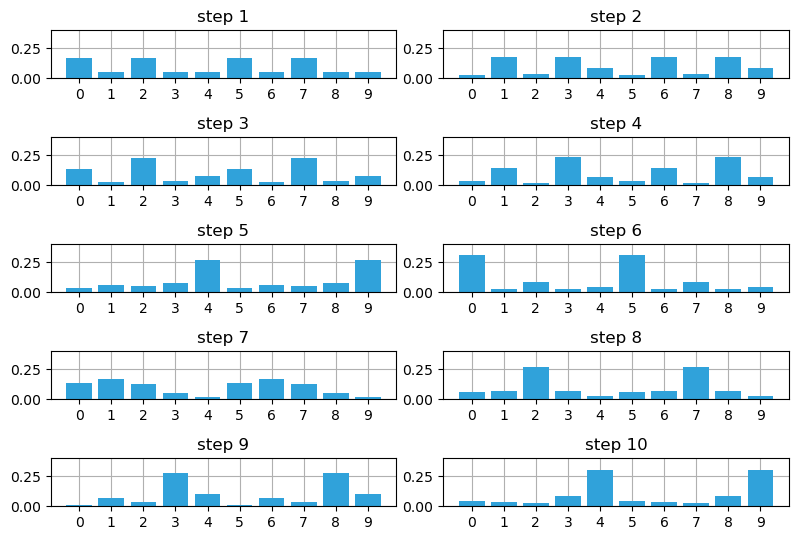

In [33]:
with figsize(y=5.5):
    measurements = [1, 0, 1, 0, 0, 1, 1, 1, 0, 0]
    for i, m in enumerate(measurements):
        likelihood = lh_hallway(hallway, z=m, z_prob=.75)
        posterior = update(likelihood, prior)
        prior = predict(posterior, 1, kernel)
        plt.subplot(5, 2, i+1)
        book_plots.bar_plot(posterior, ylim=(0, .4), title=f'step {i+1}')
    plt.tight_layout()

We quickly filtered out the bad sensor reading and converged on the most likely positions for our dog.

## Drawbacks and Limitations

Do not be mislead by the simplicity of the examples I chose. This is a robust and complete filter, and you may use the code in real world solutions. If you need a multimodal, discrete filter, this filter works.

With that said, this filter it is not used often because it has several limitations. Getting around those limitations is the motivation behind the chapters in the rest of this book.

The first problem is scaling. Our dog tracking problem used only one variable, $pos$, to denote the dog's position. Most interesting problems will want to track several things in a large space. Realistically, at a minimum we would want to track our dog's $(x,y)$ coordinate, and probably his velocity $(\dot{x},\dot{y})$ as well. We have not covered the multidimensional case, but instead of an array we use a multidimensional grid to store the probabilities at each discrete location. Each `update()` and `predict()` step requires updating all values in the grid, so a simple four variable problem would require $O(n^4)$ running time *per time step*. Realistic filters can have 10 or more variables to track, leading to exorbitant computation requirements.

The second problem is that the filter is discrete, but we live in a continuous world. The histogram requires that you model the output of your filter as a set of discrete points. A 100 meter hallway requires 10,000 positions to model the hallway to 1cm accuracy. So each update and predict operation would entail performing calculations for 10,000 different probabilities. It gets exponentially worse as we add dimensions. A 100x100 m$^2$ courtyard requires 100,000,000 bins to get 1cm accuracy.

A third problem is that the filter is multimodal. In the last example we ended up with strong beliefs that the dog was in position 4 or 9. This is not always a problem. Particle filters, which we will study later, are multimodal and are often used because of this property. But imagine if the GPS in your car reported to you that it is 40% sure that you are on D street, and 30% sure you are on Willow Avenue. 

A forth problem is that it requires a measurement of the change in state. We need a motion sensor to detect how much the dog moves. There are ways to work around this problem, but it would complicate the exposition of this chapter, so, given the aforementioned problems, I will not discuss it further.

With that said, if I had a small problem that this technique could handle I would choose to use it; it is trivial to implement, debug, and understand, all virtues.

## Tracking and Control

We have been passively tracking an autonomously moving object. But consider this very similar problem. I am automating a warehouse and want to use robots to collect all of the items for a customer's order. Perhaps the easiest way to do this is to have the robots travel on a train track. I want to be able to send the robot a destination and have it go there. But train tracks and robot motors are imperfect. Wheel slippage and imperfect motors means that the robot is unlikely to travel to exactly the position you command. There is more than one robot, and we need to know where they all are so we do not cause them to crash.

So we add sensors. Perhaps we mount magnets on the track every few feet, and use a Hall sensor to count how many magnets are passed. If we count 10 magnets then the robot should be at the 10th magnet. Of course it is possible to either miss a magnet or to count it twice, so we have to accommodate some degree of error. We can use the code from the previous section to track our robot since magnet counting is very similar to doorway sensing.

But we are not done. We've learned to never throw information away. If you have information you should use it to improve your estimate. What information are we leaving out? We know what control inputs we are feeding to the wheels of the robot at each moment in time. For example, let's say that once a second we send a movement command to the robot - move left 1 unit, move right 1 unit, or stand still.  If I send the command 'move left 1 unit' I expect that in one second from now the robot will be 1 unit to the left of where it is now. This is a simplification because I am not taking acceleration into account, but I am not trying to teach control theory. Wheels and motors are imperfect. The robot might end up 0.9 units away, or maybe 1.2 units. 

Now the entire solution is clear. We assumed that the dog kept moving in whatever direction he was previously moving. That is a dubious assumption for my dog! Robots are far more predictable. Instead of making a dubious prediction based on assumption of behavior we will feed in the command that we sent to the robot! In other words, when we call `predict()` we will pass in the commanded movement that we gave the robot along with a kernel that describes the likelihood  of that movement.

### Simulating the Train Behavior

We need to simulate an imperfect train. When we command it to move it will sometimes make a small mistake, and its sensor will sometimes return the incorrect value.

In [34]:
class Train(object):

    def __init__(self, track_len, kernel=[1.], sensor_accuracy=.9):
        self.track_len = track_len
        self.pos = 0
        self.kernel = kernel
        self.sensor_accuracy = sensor_accuracy

    def move(self, distance=1):
        """ move in the specified direction
        with some small chance of error"""

        self.pos += distance
        # insert random movement error according to kernel
        r = random.random()
        s = 0
        offset = -(len(self.kernel) - 1) / 2
        for k in self.kernel:
            s += k
            if r <= s:
                break
            offset += 1
        self.pos = int((self.pos + offset) % self.track_len)
        return self.pos

    def sense(self):
        pos = self.pos
         # insert random sensor error
        if random.random() > self.sensor_accuracy:
            if random.random() > 0.5:
                pos += 1
            else:
                pos -= 1
        return pos

With that we are ready to write the filter. We will put it in a function so that we can run it with different assumptions. I will assume that the robot always starts at the beginning of the track. The track is implemented as being 10 units long, but think of it as a track of length, say 10,000, with the magnet pattern repeated every 10 units. A length of 10 makes it easier to plot and inspect.

In [35]:
def train_filter(iterations, kernel, sensor_accuracy, 
             move_distance, do_print=True):
    track = np.array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9])
    prior = np.array([.9] + [0.01]*9)
    posterior = prior[:]
    normalize(prior)
    
    robot = Train(len(track), kernel, sensor_accuracy)
    for i in range(iterations):
        # move the robot and
        robot.move(distance=move_distance)

        # peform prediction
        prior = predict(posterior, move_distance, kernel)       

        #  and update the filter
        m = robot.sense()
        likelihood = lh_hallway(track, m, sensor_accuracy)
        posterior = update(likelihood, prior)
        index = np.argmax(posterior)

        if do_print:
            print(f'time {i}: pos {robot.pos}, sensed {m}, at position {track[robot.pos]}')
            conf = posterior[index] * 100
            print(f'        estimated position is {index} with confidence {conf:.4f}%:')            

    book_plots.bar_plot(posterior)
    if do_print:
        print()
        print('final position is', robot.pos)
        index = np.argmax(posterior)
        conf = posterior[index]*100
        print(f'Estimated position is {index} with confidence {conf:.4f}')

Read the code and make sure you understand it. Now let's do a run with no sensor or movement error. If the code is correct it should be able to locate the robot with no error. The output is a bit tedious to read, but if you are at all unsure of how the update/predict cycle works make sure you read through it carefully to solidify your understanding.

time 0: pos 4, sensed 4, at position 4
        estimated position is 4 with confidence 99.9900%:
time 1: pos 8, sensed 8, at position 8
        estimated position is 8 with confidence 100.0000%:
time 2: pos 2, sensed 2, at position 2
        estimated position is 2 with confidence 100.0000%:
time 3: pos 6, sensed 6, at position 6
        estimated position is 6 with confidence 100.0000%:

final position is 6
Estimated position is 6 with confidence 100.0000


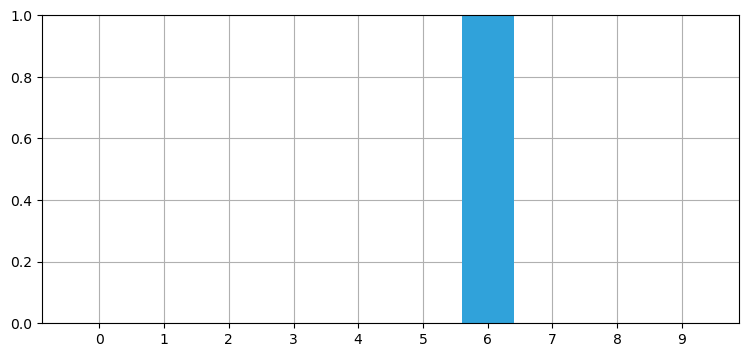

In [36]:
import random

random.seed(3)
np.set_printoptions(precision=2, suppress=True, linewidth=60)
train_filter(4, kernel=[1.], sensor_accuracy=.999,
             move_distance=4, do_print=True)

We can see that the code was able to perfectly track the robot so we should feel reasonably confident that the code is working. Now let's see how it fairs with some errors. 

time 0: pos 4, sensed 4, at position 4
        estimated position is 4 with confidence 96.0390%:
time 1: pos 8, sensed 9, at position 8
        estimated position is 9 with confidence 52.1180%:
time 2: pos 3, sensed 3, at position 3
        estimated position is 3 with confidence 88.3993%:
time 3: pos 7, sensed 8, at position 7
        estimated position is 8 with confidence 49.3174%:

final position is 7
Estimated position is 8 with confidence 49.3174


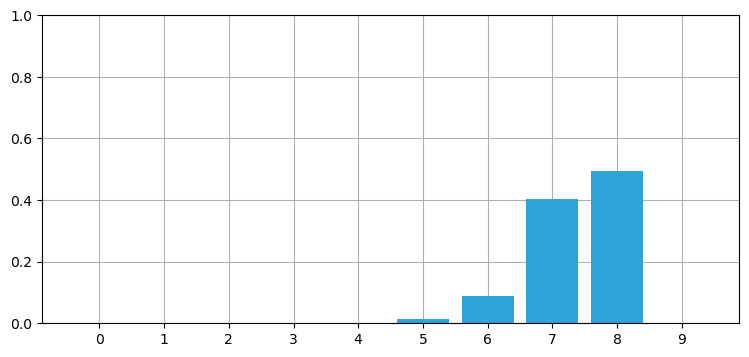

In [37]:
random.seed(5)
train_filter(4, kernel=[.1, .8, .1], sensor_accuracy=.9,
         move_distance=4, do_print=True)

There was a sensing error at time 1, but we are still quite confident in our position. 

Now let's run a very long simulation and see how the filter responds to errors.

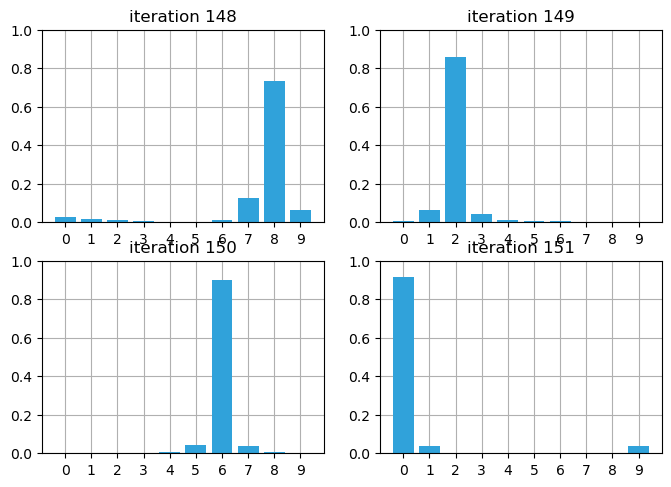

In [38]:
with figsize(y=5.5):
    for i in range (4):
        random.seed(3)
        plt.subplot(221+i)
        train_filter(148+i, kernel=[.1, .8, .1], 
                     sensor_accuracy=.8,
                     move_distance=4, do_print=False)
        plt.title (f'iteration {148 + i}')

We can see that there was a problem on iteration 149 as the confidence degrades. But within a few iterations the filter is able to correct itself and regain confidence in the estimated position.

## Bayes Theorem and the Total Probability Theorem

Математические выкладки, приведенные в этой главе, мы получили, просто рассуждая о той информации, которой мы располагаем в каждый момент времени. При этом мы открыли для себя [*теорему Байеса*] (https://en.wikipedia.org/wiki/Bayes%27_theorem) и [*теорему общей вероятности*] (https://en.wikipedia.org/wiki/Law_of_total_probability).

Теорема Байеса говорит о том, как вычислить вероятность события с учетом предыдущей информации. 

Мы реализовали функцию `update()` с вычислением этой вероятности:

$$ \mathtt{posterior} = \frac{\mathtt{likelihood}\times \mathtt{prior}}{\mathtt{normalization\, factor}}$$ 

Мы еще не разработали математику для обсуждения Байеса, но это теорема Байеса. Каждый фильтр в этой книге является выражением теоремы Байеса. В следующей главе мы будем развивать математику, но во многом это заслонит простую идею, выраженную в этом уравнении:

$$ updated\,knowledge = \big\|likelihood\,of\,new\,knowledge\times prior\, knowledge \big\|$$

где $\| \cdot\|$ выражает нормализацию выражения.

Мы пришли к этому с помощью простых рассуждений о собаке, идущей по коридору. Однако, как мы увидим, это же уравнение применимо к целому ряду проблем фильтрации. Мы будем использовать это уравнение в каждой последующей главе.

Аналогично, на шаге `predict()` вычисляется суммарная вероятность множества возможных событий. В статистике это известно как *теорема о суммарной вероятности*, и мы также рассмотрим ее в следующей главе после разработки некоторых вспомогательных математических выкладок.

Пока же мне нужно, чтобы вы поняли, что теорема Байеса - это формула для включения новой информации в существующую.

## Резюме

Код очень короткий, но результат впечатляет! Мы реализовали одну из форм байесовского фильтра. Мы узнали, как начать с отсутствия информации и получить информацию от зашумленных датчиков. Даже несмотря на то, что датчики в этой главе очень шумные (точность большинства датчиков, например, превышает 80%), мы быстро сходимся к наиболее вероятному положению собаки. Мы узнали, что шаг предсказания всегда ухудшает наши знания, но добавление еще одного измерения, даже если оно может содержать шум, улучшает наши знания, позволяя нам сходиться к наиболее вероятному результату.

Эта книга в основном посвящена фильтру Калмана. Математика в ней другая, но логика точно такая же, как и в этой главе. Он использует байесовские рассуждения для формирования оценок на основе комбинации измерений и моделей процессов. 

**Если вы сможете понять эту главу, вы сможете понять и реализовать фильтры Калмана.** Я не могу не подчеркнуть это. Если что-то непонятно, вернитесь назад, перечитайте эту главу и поиграйте с кодом. Остальная часть этой книги будет построена на алгоритмах, которые мы здесь используем. Если вы не поймете, почему работает этот фильтр, вы не сможете успешно работать с остальным материалом. Однако если вы поймете основную идею - умножение вероятностей при измерении и сдвиг вероятностей при обновлении приводят к сходящемуся решению, - то, изучив немного математики, вы будете готовы реализовать фильтр Калмана.

## References

 * [1] D. Fox, W. Burgard, and S. Thrun. "Monte carlo localization: Efficient position estimation for mobile robots." In *Journal of Artifical Intelligence Research*, 1999.
 
 http://www.cs.cmu.edu/afs/cs/project/jair/pub/volume11/fox99a-html/jair-localize.html


 * [2] Dieter Fox, et. al. "Bayesian Filters for Location Estimation". In *IEEE Pervasive Computing*, September 2003.
 
 http://swarmlab.unimaas.nl/wp-content/uploads/2012/07/fox2003bayesian.pdf
 
 
 * [3] Sebastian Thrun. "Artificial Intelligence for Robotics".
 
 https://www.udacity.com/course/cs373
 
 
 * [4] Khan Acadamy. "Introduction to the Convolution"
 
 https://www.khanacademy.org/math/differential-equations/laplace-transform/convolution-integral/v/introduction-to-the-convolution
 
 
* [5] Wikipedia. "Convolution"

 http://en.wikipedia.org/wiki/Convolution

* [6] Wikipedia. "Law of total probability"

  http://en.wikipedia.org/wiki/Law_of_total_probability
  
* [7] Wikipedia. "Time Evolution"

 https://en.wikipedia.org/wiki/Time_evolution
 
* [8] We need to rethink how we teach statistics from the ground up
 
 http://www.statslife.org.uk/opinion/2405-we-need-to-rethink-how-we-teach-statistics-from-the-ground-up